# 🖐️ HandSpeak.ai - Industry Standard Training Pipeline

**Objective**: Train a Production-Grade Transformer for ASL Character Recognition.
**Input**: 30-frame sequences of 21 MediaPipe hand landmarks (x,y,z).

## 🚀 Industry Standard Features
- **Mixed Precision Training (AMP)**: Accelerates training on T4/V100 GPUs while reducing memory usage.
- **Advanced Callbacks**: Early Stopping, ReduceLROnPlateau, Gradient Clipping.
- **Robust Preprocessing**: Wrist centralization, Scale Normalization, Rotation Alignment.
- **Data Augmentation**: Simulates real-world variance (Rotation, Scale, Noise, Jitter).
- **Comprehensive Metrics**: Per-Class Accuracy, Top-3 Accuracy, Confusion Matrix, Classification Report.
- **Model Introspection**: Parameter counting and layer visualization using `torchinfo`.
- **Production Export**: Validated ONNX export with inference benchmarking.

## 1. Setup & Environment

In [22]:
!pip install -q torchinfo onnxruntime seaborn onnxscript

import os
import json
import random
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast # Mixed Precision
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter
import onnxruntime as ort

# ----------------------------
# CONFIGURATION
# ----------------------------
CONFIG = {
    "FRAMES": 30,
    "LANDMARKS": 21,
    "DIMS": 3,
    "NUM_CLASSES": 26,
    "BATCH_SIZE": 128,      # Increased for AMP efficiency
    "EPOCHS": 100,          # Higher epoch limit with Early Stopping
    "LR": 1e-3,
    "PATIENCE": 10,         # Early Stopping Patience
    "SEED": 42,
    "NUM_WORKERS": os.cpu_count()
}

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(CONFIG['SEED'])

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Training on: {DEVICE}")
if torch.cuda.is_available():
    print(f"   GPU Model: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 16.7 MB/s eta 0:00:00
🔥 Training on: cuda
   GPU Model: Tesla T4


In [11]:
from google.colab import drive
drive.mount('/content/drive')

# UPDATE THIS PATH TO YOUR DATASET LOCATION
DATASET_ROOT = '/content/drive/MyDrive/dataset_v2_mobile/landmarks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Preprocessing & Augmentation Engine
Robust preprocessing is critical for generalization across different users and camera angles.

In [12]:
class HandAugmentor:
    """Applies 3D rotation, scaling, and noise to simulate user variance."""

    @staticmethod
    def rotate_frame(frame, angle_deg):
        rad = np.radians(angle_deg)
        c, s = np.cos(rad), np.sin(rad)
        # Rotate around Z-axis (2D plane of screen)
        R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
        return np.dot(frame, R.T)

    @staticmethod
    def augment(sequence: np.ndarray) -> np.ndarray:
        # sequence: (T, 21, 3)

        # 1. Random Rotation (-25 to +25 degrees)
        angle = np.random.uniform(-25, 25)

        # 2. Random Scale (0.85x to 1.15x)
        scale = np.random.uniform(0.85, 1.15)

        # 3. Random Shift/Translation (Global)
        shift = np.random.uniform(-0.08, 0.08, size=(1, 3))

        processed = []
        for frame in sequence:
            f = HandAugmentor.rotate_frame(frame, angle)
            f = f * scale
            f = f + shift
            processed.append(f)

        processed = np.array(processed)

        # 4. Pixel Noise (Independent per frame)
        noise = np.random.normal(0, 0.002, processed.shape) # Micro-jitter
        return processed + noise

class Preprocessor:
    """Canonicalizes the hand: Centers Wrist, Normalizes Size, Aligns Rotation."""

    def __init__(self, target_frames=30):
        self.target_frames = target_frames

    def process(self, raw_sequence) -> np.ndarray:
        data = np.array(raw_sequence, dtype=np.float32)
        if data.ndim == 2: data = data[np.newaxis, ...]

        # 1. Resample
        data = self._resample(data)

        # 2. Normalize Frame-by-Frame
        processed_frames = [self._normalize_frame(f) for f in data]
        return np.stack(processed_frames)

    def _resample(self, data):
        T = data.shape[0]
        if T == self.target_frames: return data
        if T < self.target_frames:
            # Pad with last frame
            padding = np.tile(data[-1], (self.target_frames - T, 1, 1))
            return np.concatenate([data, padding], axis=0)
        else:
            # Uniform sample
            idx = np.linspace(0, T-1, self.target_frames, dtype=int)
            return data[idx]

    def _normalize_frame(self, frame):
        WRIST, INDEX_MCP, MIDDLE_MCP = 0, 5, 9

        # Center
        frame -= frame[WRIST]

        # Scale
        palm_size = np.linalg.norm(frame[MIDDLE_MCP])
        if palm_size > 1e-6: frame /= palm_size

        # Rotate Alignment (Align Wrist->Index to Y-axis)
        v = frame[INDEX_MCP]
        angle = np.arctan2(v[0], v[1])
        theta = -angle
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
        frame = np.dot(frame, R.T)

        return frame

## 3. Data Loading & Exploratory Data Analysis (EDA)

📂 Scanning /content/drive/MyDrive/dataset_v2_mobile/landmarks...
   Found 26 files corresponding to data batches.
✅ Successfully loaded 3153 samples.


/tmp/ipython-input-496138028.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


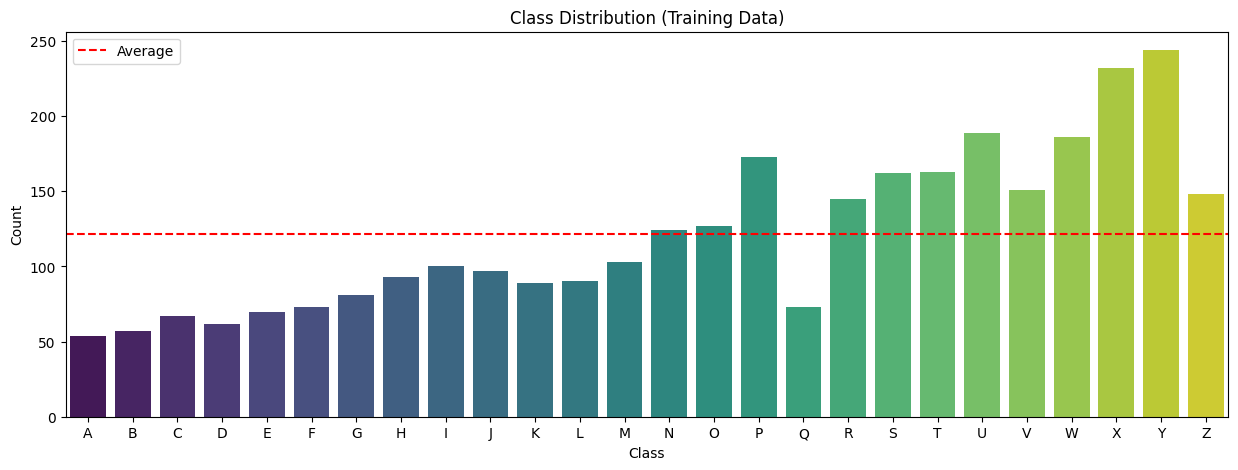

In [13]:
CLASSES = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}
IDX_TO_CLASS = {i: c for c, i in CLASS_TO_IDX.items()}

def load_dataset(root_dir):
    samples = []
    labels = []

    pattern = os.path.join(root_dir, "*_landmarks.json")
    files = glob(pattern)
    print(f"📂 Scanning {root_dir}...")
    print(f"   Found {len(files)} files corresponding to data batches.")

    for fpath in files:
        try:
            with open(fpath, 'r') as f:
                data = json.load(f)
                if isinstance(data, dict): data = [data]

                for item in data:
                    if 'landmarks' in item and len(item['landmarks']) == 21:
                        samples.append(item['landmarks'])
                        labels.append(CLASS_TO_IDX[item['letter']])
        except Exception as e:
            pass # Skip corrupted files

    return samples, labels

# Load Data
try:
    raw_samples, raw_labels = load_dataset(DATASET_ROOT)
    print(f"✅ Successfully loaded {len(raw_samples)} samples.")

    # Class Distribution Analysis
    counts = Counter([IDX_TO_CLASS[l] for l in raw_labels])

    plt.figure(figsize=(15, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
    plt.title("Class Distribution (Training Data)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.axhline(sum(counts.values())/len(counts), color='r', linestyle='--', label='Average')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"⚠️ Error loading data: {e}")
    raw_samples, raw_labels = [], []

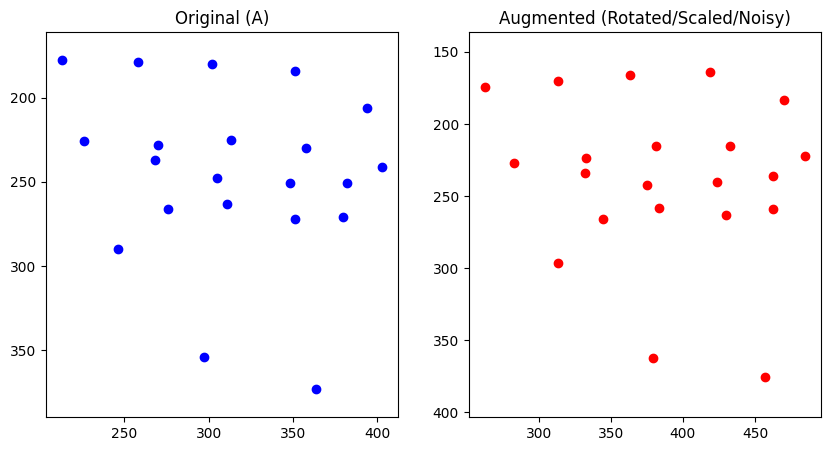

In [14]:
# Augmentation Visualization (Before vs After)
if raw_samples:
    idx = 0
    sample = np.array(raw_samples[idx])

    # Create a dummy sequence for augmentation demo
    seq_input = np.tile(sample[np.newaxis, ...], (30, 1, 1))
    aug_seq = HandAugmentor.augment(seq_input)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original
    ax[0].scatter(sample[:, 0], sample[:, 1], c='b', label='Joints')
    ax[0].set_title(f"Original ({IDX_TO_CLASS[raw_labels[idx]]})")
    ax[0].invert_yaxis()
    ax[0].axis('equal')

    # Augmented
    ax[1].scatter(aug_seq[0, :, 0], aug_seq[0, :, 1], c='r', label='Augmented')
    ax[1].set_title("Augmented (Rotated/Scaled/Noisy)")
    ax[1].invert_yaxis()
    ax[1].axis('equal')

    plt.show()

## 4. Dataset & Transformer Architecture

In [17]:
class ASLDataset(Dataset):
    def __init__(self, samples, labels, augment=False):
        self.samples = samples
        self.labels = labels
        self.augment = augment
        self.preprocessor = Preprocessor(target_frames=30)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        raw = self.samples[idx]
        base = np.array(raw, dtype=np.float32)

        # Convert static sample to sequence
        sequence = np.tile(base[np.newaxis, ...], (30, 1, 1))

        if self.augment:
            sequence = HandAugmentor.augment(sequence)

        # Preprocess (Canonicalize)
        processed = self.preprocessor.process(sequence)

        # Flatten: (30, 21, 3) -> (30, 63)
        x = torch.tensor(processed, dtype=torch.float32).view(30, -1)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

class HandTransformer(nn.Module):
    def __init__(self, num_classes=26, d_model=128, nhead=4, num_layers=4, dim_feedforward=256, dropout=0.3):
        super().__init__()
        self.pos_encoder = nn.Parameter(torch.randn(1, 30, d_model) * 0.02)
        self.input_proj = nn.Sequential(nn.Linear(63, d_model), nn.LayerNorm(d_model), nn.ReLU())

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # (Batch, Seq, Feat)
            norm_first=True    # Pre-Norm for better stability
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, 64),
            nn.GELU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (B, 30, 63)
        # Project & Add Positional Encoding
        x = self.input_proj[0](x) # Linear
        x = self.input_proj[1](x) + self.pos_encoder # Norm + Pos
        x = self.input_proj[2](x) # ReLU

        # Attend
        x = self.transformer(x)

        # Global Average Pooling over time dimension
        x = x.mean(dim=1)

        # Classify
        return self.head(x)

## 5. Training Loop with Mixed Precision & Callbacks

In [19]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(
    raw_samples, raw_labels,
    test_size=0.2,
    stratify=raw_labels,
    random_state=CONFIG['SEED']
)

train_ds = ASLDataset(X_train, y_train, augment=True)
val_ds = ASLDataset(X_val, y_val, augment=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)

# Handling Imbalance
label_counts = Counter(y_train)
total_samples = sum(label_counts.values())
weights = [total_samples / (CONFIG['NUM_CLASSES'] * label_counts.get(i, 1)) for i in range(CONFIG['NUM_CLASSES'])]
class_weights = torch.FloatTensor(weights).to(DEVICE)

# Model Init
model = HandTransformer(num_classes=CONFIG['NUM_CLASSES']).to(DEVICE)
summary(model, input_size=(1, 30, 63)) # Model Introspection

# Optimization
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['LR'], weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
scaler = GradScaler() # For Mixed Precision

print("🚀 Starting Training Loop...")

best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
patience_counter = 0

for epoch in range(CONFIG['EPOCHS']):
    start_time = time.time()
    model.train()
    train_loss, correct, total = 0, 0, 0

    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()

        # Mixed Precision Forward
        with autocast():
            out = model(X)
            loss = criterion(out, y)

        # Mixed Precision Backward
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient Clipping
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)

    # Validation
    model.eval()
    val_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            loss = criterion(out, y)
            val_loss += loss.item()
            _, pred = out.max(1)
            v_correct += pred.eq(y).sum().item()
            v_total += y.size(0)

    # Metrics
    t_acc = 100 * correct / total
    v_acc = 100 * v_correct / v_total
    avg_t_loss = train_loss / len(train_loader)
    avg_v_loss = val_loss / len(val_loader)

    history['train_loss'].append(avg_t_loss)
    history['train_acc'].append(t_acc)
    history['val_loss'].append(avg_v_loss)
    history['val_acc'].append(v_acc)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1:03d}/{CONFIG['EPOCHS']} | Time: {epoch_time:.1f}s | Train Loss: {avg_t_loss:.4f} Acc: {t_acc:.1f}% | Val Loss: {avg_v_loss:.4f} Acc: {v_acc:.1f}%")

    # Callbacks
    scheduler.step(v_acc)

    if v_acc > best_val_acc:
        best_val_acc = v_acc
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= CONFIG['PATIENCE']:
            print(f"🛑 Early Stopping! No improvement for {CONFIG['PATIENCE']} epochs.")
            break

print(f"🏆 Best Validation Accuracy: {best_val_acc:.2f}%")

🚀 Starting Training Loop...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/tmp/ipython-input-547074432.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # For Mixed Precision
/tmp/ipython-input-547074432.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 001/100 | Time: 6.2s | Train Loss: 2.8515 Acc: 23.3% | Val Loss: 2.1955 Acc: 61.3%
Epoch 002/100 | Time: 3.6s | Train Loss: 1.9499 Acc: 61.2% | Val Loss: 1.4734 Acc: 84.8%
Epoch 003/100 | Time: 3.5s | Train Loss: 1.3757 Acc: 82.3% | Val Loss: 1.0818 Acc: 93.3%
Epoch 004/100 | Time: 4.0s | Train Loss: 1.0896 Acc: 93.7% | Val Loss: 0.9545 Acc: 97.9%
Epoch 005/100 | Time: 7.3s | Train Loss: 0.9643 Acc: 96.6% | Val Loss: 0.8553 Acc: 99.2%
Epoch 006/100 | Time: 5.2s | Train Loss: 0.9010 Acc: 97.7% | Val Loss: 0.8223 Acc: 99.7%
Epoch 007/100 | Time: 5.0s | Train Loss: 0.8727 Acc: 98.4% | Val Loss: 0.8028 Acc: 99.5%
Epoch 008/100 | Time: 3.5s | Train Loss: 0.8501 Acc: 98.6% | Val Loss: 0.8070 Acc: 98.4%
Epoch 009/100 | Time: 6.1s | Train Loss: 0.8469 Acc: 97.8% | Val Loss: 0.7784 Acc: 99.5%
Epoch 010/100 | Time: 6.4s | Train Loss: 0.8184 Acc: 99.0% | Val Loss: 0.7777 Acc: 99.4%
Epoch 011/100 | Time: 3.6s | Train Loss: 0.7962 Acc: 99.4% | Val Loss: 0.7632 Acc: 99.7%
Epoch 012/100 | Time:

## 6. Advanced Evaluation Metrics


📊 Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        11
           B       1.00      1.00      1.00        11
           C       1.00      1.00      1.00        13
           D       1.00      1.00      1.00        12
           E       1.00      1.00      1.00        14
           F       1.00      1.00      1.00        15
           G       1.00      1.00      1.00        16
           H       1.00      0.95      0.97        19
           I       1.00      1.00      1.00        20
           J       0.95      1.00      0.97        19
           K       1.00      1.00      1.00        18
           L       1.00      1.00      1.00        18
           M       1.00      1.00      1.00        21
           N       1.00      0.96      0.98        25
           O       0.96      1.00      0.98        25
           P       1.00      1.00      1.00        35
           Q       1.00      1.00      1.00        15


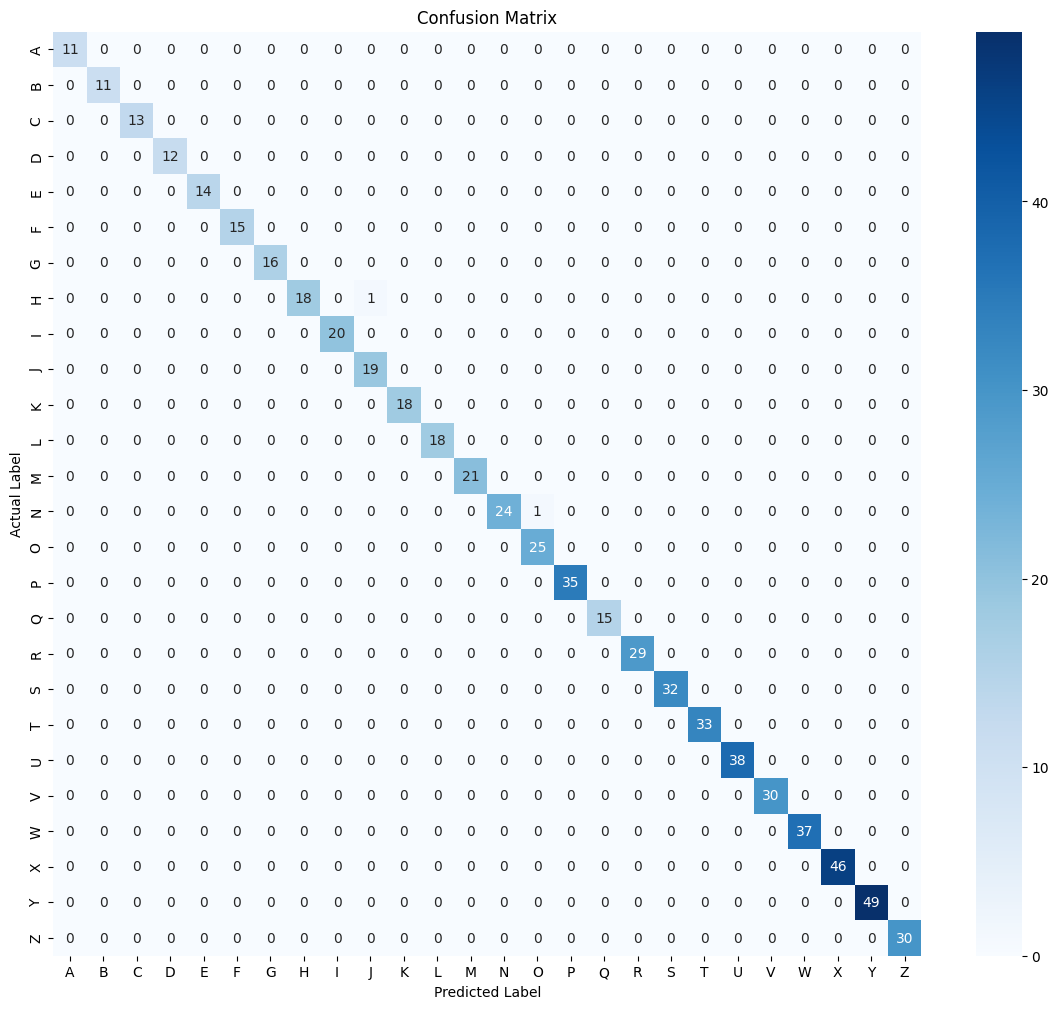

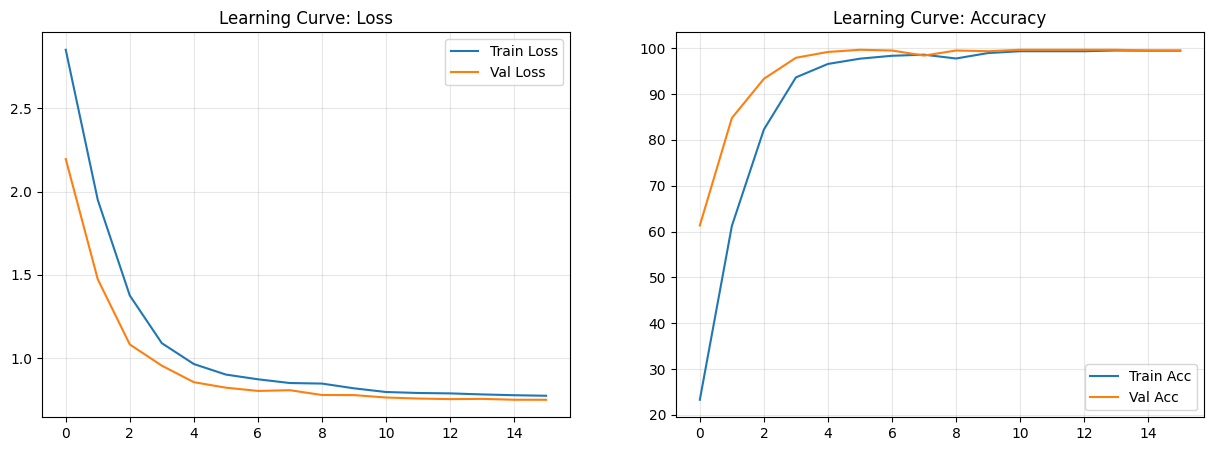

In [20]:
# Load Best Model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        out = model(X)
        probs = torch.softmax(out, dim=1)
        _, pred = out.max(1)

        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 1. Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(all_targets, all_preds, target_names=CLASSES))

# 2. Top-3 Accuracy
top3_acc = top_k_accuracy_score(all_targets, all_probs, k=3, labels=range(CONFIG['NUM_CLASSES']))
print(f"\n🎯 Top-3 Accuracy: {top3_acc*100:.2f}%")

# 3. Confusion Matrix Plot
plt.figure(figsize=(14, 12))
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. Training History Curves
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='Train Loss')
ax[0].plot(history['val_loss'], label='Val Loss')
ax[0].set_title("Learning Curve: Loss")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(history['train_acc'], label='Train Acc')
ax[1].plot(history['val_acc'], label='Val Acc')
ax[1].set_title("Learning Curve: Accuracy")
ax[1].legend()
ax[1].grid(True, alpha=0.3)
plt.show()

## 7. ONNX Export & Verification

In [23]:
DUMMY_INPUT = torch.randn(1, 30, 63).to(DEVICE)
ONNX_PATH = "asl_model_v2.onnx"

# Export
torch.onnx.export(
    model,
    DUMMY_INPUT,
    ONNX_PATH,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}},
    opset_version=12
)
print(f"✅ Model exported to {ONNX_PATH}")

# Verify with ONNX Runtime
ort_session = ort.InferenceSession(ONNX_PATH)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Compute PyTorch Output
torch_out = model(DUMMY_INPUT)

# Compute ONNX Output
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(DUMMY_INPUT)}
ort_out = ort_session.run(None, ort_inputs)

# Compare
np.testing.assert_allclose(to_numpy(torch_out), ort_out[0], rtol=1e-03, atol=1e-05)
print("✅ ONNX Model outputs match PyTorch outputs!")

# Benchmark Inference Speed
print("\n⏱️ Benchmarking ONNX Inference (CPU)...")
latencies = []
for _ in range(100):
    start = time.time()
    ort_session.run(None, ort_inputs)
    latencies.append(time.time() - start)

avg_ms = np.mean(latencies) * 1000
print(f"Average Latency: {avg_ms:.2f} ms per sample")
print(f"Estimated Throughput: {1000/avg_ms:.2f} FPS")

/tmp/ipython-input-28253707.py:5: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0129 16:28:46.071000 418 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 12 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `HandTransformer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `HandTransformer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 19 of general pattern rewrite rules.
✅ Model exported to asl_model_v2.onnx
✅ ONNX Model outputs match PyTorch outputs!

⏱️ Benchmarking ONNX Inference (CPU)...
Average Latency: 1.48 ms per sample
Estimated Throughput: 677.39 FPS
